<a href="https://colab.research.google.com/github/Lexaun-chen/STAT-4830-Group-Project/blob/main/notebooks/week3_live_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Basic Model


In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch
import matplotlib.pyplot as plt


class DiagonalLinear(nn.Module):
    def __init__(self, size):
        super(DiagonalLinear, self).__init__()
        self.size = size
        self.diag = nn.Parameter(torch.ones(size))  # Initialize diagonal entries as ones
    def forward(self, x):
        # Construct diagonal matrix
        diag_matrix = torch.diag(self.diag)
        return x @ diag_matrix


class MNL(nn.Module):
    def __init__(self, OptSize):
        super().__init__()
        self.input_linear = DiagonalLinear(OptSize)

    def forward(self, e):
        mask = e == 1
        e = self.input_linear(e)
        masked_e = torch.where(mask == 1, e, float('-inf'))
        masked_softmax_e = F.softmax(masked_e, dim=-1)
        return masked_softmax_e, e

# Application Instance

In [ ]:
"""
1. Get Synthetic Hypothetical Data
"""

import numpy as np
import itertools
import pandas as pd


def generate_one_hot(probabilities):
    probabilities = np.array(probabilities)
    p_index = np.random.choice(len(probabilities), p=probabilities)
    one_hot = np.zeros_like(probabilities)
    one_hot[p_index] = 1
    return one_hot


product_set = [0, 1, 2, 3]
offer_set = [0, 1, 2, 3]
X = []
Y = []


hypothetical_choice_p = [[0.98, 0.02, 0, 0],
                         [0.5, 0, 0.5, 0],
                         [0.5, 0, 0, 0.5],
                         [0, 0.5, 0.5, 0],
                         [0, 0.5, 0, 0.5],
                         [0, 0, 0.9, 0.1],
                         [0.49, 0.01, 0.5, 0],
                         [0.49, 0.01, 0, 0.5],
                         [0.5, 0, 0.45, 0.05],
                         [0, 0.5, 0.45, 0.05],
                         [0.49, 0.01, 0.45, 0.05]]

index = 0
for r in range(2, len(offer_set) + 1):
    for subset in itertools.combinations(offer_set, r):
        binary_subset = [1 if x in subset else 0 for x in offer_set]
        p = hypothetical_choice_p[index]
        for _ in range(200):
            X.append(binary_subset)
            Y.append(generate_one_hot(p).reshape((1, len(product_set))))
        index += 1


np.random.seed(10)
X = np.array(X)
Y = np.concatenate(Y, axis=0)
dataset = np.concatenate((X, Y), axis=1)
df = pd.DataFrame(dataset, columns=['X' + str(i) for i in product_set] + ['Y' + str(i) for i in product_set])
csv_file = 'hypothetical-4p-test.csv'
df.to_csv(csv_file, index=False)


X = []
Y = []
np.random.seed(42)
index = 0
for r in range(2, len(offer_set) + 1):
    for subset in itertools.combinations(offer_set, r):
        binary_subset = [1 if x in subset else 0 for x in offer_set]
        p = hypothetical_choice_p[index]
        for _ in range(2000):
            X.append(binary_subset)
            Y.append(generate_one_hot(p).reshape((1, len(product_set))))
        index += 1


X = np.array(X)
Y = np.concatenate(Y, axis=0)
dataset = np.concatenate((X, Y), axis=1)
df = pd.DataFrame(dataset, columns=['X' + str(i) for i in product_set] + ['Y' + str(i) for i in product_set])
csv_file = 'hypothetical-4p-train.csv'
df.to_csv(csv_file, index=False)



Epoch [5/100], Original Loss: 0.3781, Frequency Loss: 0.17702217
Epoch [10/100], Original Loss: 0.3738, Frequency Loss: 0.16768919
Epoch [15/100], Original Loss: 0.3701, Frequency Loss: 0.15930612
Epoch [20/100], Original Loss: 0.3670, Frequency Loss: 0.15204103
Epoch [25/100], Original Loss: 0.3646, Frequency Loss: 0.14598328
Epoch [30/100], Original Loss: 0.3627, Frequency Loss: 0.14113036
Epoch [35/100], Original Loss: 0.3612, Frequency Loss: 0.13739477
Epoch [40/100], Original Loss: 0.3602, Frequency Loss: 0.13462790
Epoch [45/100], Original Loss: 0.3594, Frequency Loss: 0.13265168
Epoch [50/100], Original Loss: 0.3589, Frequency Loss: 0.13128717
Epoch [55/100], Original Loss: 0.3586, Frequency Loss: 0.13037456
Epoch [60/100], Original Loss: 0.3584, Frequency Loss: 0.12978265
Epoch [65/100], Original Loss: 0.3583, Frequency Loss: 0.12941041
Epoch [70/100], Original Loss: 0.3582, Frequency Loss: 0.12918382
Epoch [75/100], Original Loss: 0.3581, Frequency Loss: 0.12905075
Epoch [80/1

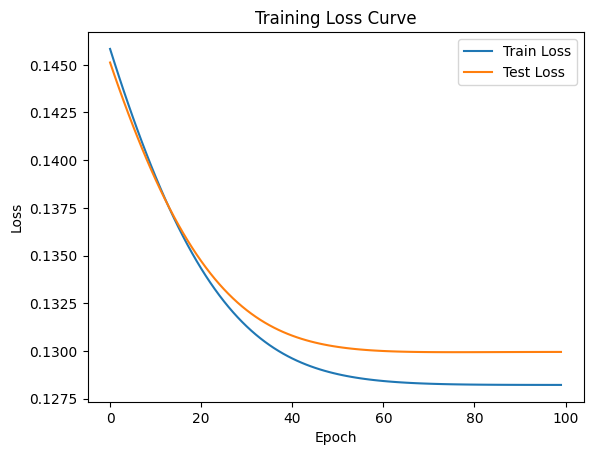

In [ ]:
"""
2. Train Test MNL Model
"""

import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
import torch
import pandas as pd


def calc_freq(X, Y):
    X = X.float()
    Y = Y.float()
    unique_X, inverse_indices = torch.unique(X, dim=0, return_inverse=True)
    new_Y = torch.zeros_like(Y)
    for k in range(unique_X.shape[0]):
        mask = (inverse_indices == k)
        avg_y = torch.mean(Y[mask], dim=0)
        new_Y[mask] = avg_y
    return new_Y


def log_likelihood(out, y, safe_log=0):
    ones_indices = y == 1
    probabilities = out[ones_indices]
    negative_log_probabilities = -torch.log(probabilities + safe_log)
    total_negative_log_prob = torch.sum(negative_log_probabilities)
    return total_negative_log_prob / y.shape[0]


def train_synthetic(loss_name, num_epochs):
    input_dim = 4
    main_network = MNL(input_dim)
    train_file_path = 'hypothetical-4p-train.csv'
    test_file_path = 'hypothetical-4p-test.csv'
    df_train = pd.read_csv(train_file_path)
    df_test = pd.read_csv(test_file_path)
    X_columns = [col for col in df_train.columns if col.startswith('X')]
    Y_columns = [col for col in df_train.columns if col.startswith('Y')]
    X_train = torch.tensor(df_train[X_columns].values, dtype=torch.float)
    Y_train = torch.tensor(df_train[Y_columns].values, dtype=torch.float)
    Y_train_freq = calc_freq(X_train, Y_train)
    X_test = torch.tensor(df_test[X_columns].values, dtype=torch.float)
    Y_test = torch.tensor(df_test[Y_columns].values, dtype=torch.float)
    Y_test_freq = calc_freq(X_test, Y_test)
    optimizer = Adam(main_network.parameters(), lr=0.01, weight_decay=0)
    train_losses = []
    test_losses = []
    in_loss = None
    if loss_name == 'NLL':
        L = log_likelihood
    else:
        L = nn.MSELoss()
    for epoch in range(num_epochs):
        output, _ = main_network(X_train)
        loss = L(output, Y_train)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        in_loss = loss.item()
        train_losses.append(in_loss)
        with torch.no_grad():
            freq_loss = L(output, Y_train_freq)
            test_output, _ = main_network(X_test)
            test_loss = L(test_output, Y_test)
            test_losses.append(test_loss.item())
        if (epoch + 1) % 5 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Original Loss: {loss.item() ** 0.5:.4f},'
                  f' Frequency Loss: {freq_loss.item() ** 0.5:.8f}')
    final_output, _ = main_network(X_test)
    torch.save(main_network, 'MNL_Model-hyp.pth')
    return in_loss ** 0.5, freq_loss.item() ** 0.5,\
        L(final_output, Y_test).item() ** 0.5, L(final_output, Y_test_freq).item() ** 0.5, train_losses, test_losses


Loss_Name = 'MSE'
epochs = 100
in_sample_RMSE, in_sample_RMSE_Freq, out_sample_RMSE, out_sample_RMSE_Freq, train_loss, test_loss = train_synthetic(Loss_Name, epochs)
print('in_sample_RMSE, in_sample_RMSE_Freq, out_sample_RMSE, out_sample_RMSE_Freq')
print(in_sample_RMSE,  in_sample_RMSE_Freq, out_sample_RMSE, out_sample_RMSE_Freq)
plt.plot(train_loss, label='Train Loss')
plt.plot(test_loss, label='Test Loss')
plt.legend()
plt.title('Training Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [ ]:
import numpy as np

def generate_synthetic_choice_data(num_alternatives, num_observations, utilities):
    """
    Generates synthetic choice data with predefined utilities.

    Args:
        num_alternatives: The number of alternatives in the choice set.
        num_observations: The number of choice observations to generate.
        utilities: A 1D numpy array representing the utilities for each alternative.

    Returns:
        A 2D numpy array where each row represents a choice observation
        and each column represents an alternative. The value in each cell
        indicates whether the corresponding alternative was chosen (1) or not (0).
    """

    choice_data = np.zeros((num_observations, num_alternatives))

    for i in range(num_observations):
        # Add random noise to utilities
        noisy_utilities = utilities + np.random.gumbel(size=num_alternatives)

        # Choose the alternative with the highest utility
        choice = np.argmax(noisy_utilities)

        # Update choice data
        choice_data[i, choice] = 1

    return choice_data

In [ ]:
# Generate synthetic data
num_alternatives = 4
num_observations = 10000
ground_truth_utilities = np.array([0.5, 0.3, 0.2, 0.1])
choice_data = generate_synthetic_choice_data(num_alternatives, num_observations, ground_truth_utilities)

# Convert data to PyTorch tensors
X = torch.ones((num_observations, 4)).float()  # Offersets as input
Y = torch.from_numpy(choice_data).float()  # Choices as target (same as input for MNL)

# Create and train the MNL model
model = MNL(num_alternatives)
optimizer = Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()  # You can use other loss functions as well

num_epochs = 1000
for epoch in range(num_epochs):
    optimizer.zero_grad()
    output, utilities_captured = model(X)  # Get predicted probabilities and utilities
    loss = criterion(output, Y)
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

# Compare captured utilities with ground truth
print("\nGround Truth Utilities:", ground_truth_utilities)
print("Captured Utilities:", utilities_captured[-1].detach().numpy())  # Get utilities from last batch


Epoch [10/1000], Loss: 0.1873
Epoch [20/1000], Loss: 0.1872
Epoch [30/1000], Loss: 0.1871
Epoch [40/1000], Loss: 0.1869
Epoch [50/1000], Loss: 0.1868
Epoch [60/1000], Loss: 0.1867
Epoch [70/1000], Loss: 0.1866
Epoch [80/1000], Loss: 0.1865
Epoch [90/1000], Loss: 0.1864
Epoch [100/1000], Loss: 0.1864
Epoch [110/1000], Loss: 0.1863
Epoch [120/1000], Loss: 0.1862
Epoch [130/1000], Loss: 0.1862
Epoch [140/1000], Loss: 0.1861
Epoch [150/1000], Loss: 0.1861
Epoch [160/1000], Loss: 0.1861
Epoch [170/1000], Loss: 0.1860
Epoch [180/1000], Loss: 0.1860
Epoch [190/1000], Loss: 0.1860
Epoch [200/1000], Loss: 0.1860
Epoch [210/1000], Loss: 0.1860
Epoch [220/1000], Loss: 0.1860
Epoch [230/1000], Loss: 0.1859
Epoch [240/1000], Loss: 0.1859
Epoch [250/1000], Loss: 0.1859
Epoch [260/1000], Loss: 0.1859
Epoch [270/1000], Loss: 0.1859
Epoch [280/1000], Loss: 0.1859
Epoch [290/1000], Loss: 0.1859
Epoch [300/1000], Loss: 0.1859
Epoch [310/1000], Loss: 0.1859
Epoch [320/1000], Loss: 0.1859
Epoch [330/1000],